# UK Housing Dataset - Obtain, Scrub & Explore

Author: Tijl Cleynhens

This notebook documents the data exploration and preprocessing steps used in the housing price analysis project. It covers loading the dataset, cleaning and preparing the variables, inspecting missing values, handling outliers, and performing initial exploratory data analysis. The goal is to create a reliable and well-structured dataset that can be used for modeling and further analysis.

# 1. Obtain data
-Load the raw dataset from the configured file path using pandas.read_csv.

-Use low_memory=False to avoid mixed-type warnings and ensure consistent type handling.

-Store the result in a DataFrame for further analysis and cleaning.

-Print basic information such as the dataset shape and the first set of column names to confirm the load was successful and to get an initial overview of the structure.

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- CONFIG ----------
file_path = r"C:/Users/tijl0/Desktop/Machine Learning/Project_Python/price_paid_records.csv"

# ---------- OBTAIN ----------
# new machine, so read it all
df = pd.read_csv(file_path, low_memory=False)

print(" Dataset loaded")
print("Shape:", df.shape)
print("columns (first 15):", df.columns.tolist()[:15])


✅ Dataset loaded
Shape: (22489348, 11)
columns (first 15): ['Transaction unique identifier', 'Price', 'Date of Transfer', 'Property Type', 'Old/New', 'Duration', 'Town/City', 'District', 'County', 'PPDCategory Type', 'Record Status - monthly file only']


# 2. Scrub data
-Rename selected columns to consistent, lowercase names using a predefined mapping.

-Standardize all column names by stripping whitespace, converting to lowercase, and replacing spaces or hyphens with underscores.

-Inspect missing values to identify which fields will require imputation.

-Fill missing numeric values with the median of each column to maintain reasonable distributions.

-Fill missing categorical fields with a default label and convert those columns to categorical types.

-Detect price outliers using the IQR method, report how many are present, remove them from the dataset, and drop the temporary indicator column.

-Convert the existing month column into an ordered categorical type so that its natural sequence is preserved during analysis.

In [ ]:
# ---------- SCRUB / PREP ----------

# 1. Rename columns
rename_map = {
    "Price": "price",
    "Date of Transfer": "date_of_transfer",
    "Property Type": "property_type",
    "Old/New": "new_build_flag",
    "Duration": "tenure",
    "Town/City": "town",
    "District": "district",
    "County": "county"
}
df = df.rename(columns=rename_map)

# 2. Clean all columns: lowercase, underscores, no spaces
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
    .str.replace("-", "_")
)


# 3. Inpect NA-values
na_counts = df.isna().sum().sort_values(ascending=False)
print("\nMissing values(top 15):\n", na_counts.head(15))

# 4. Fill numeric NA-values
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].median())

# 5. Detect categoric columns and fill with 'Unknown' 
cat_candidates = [
    "property_type",
    "new_build_flag",
    "tenure",
    "town",
    "district",
    "county"
]
for col in cat_candidates:
    if col in df.columns:
        df[col] = df[col].fillna("Unknown")
        df[col] = df[col].astype("category")

# 6. Find outliers in price with IQR
if "price" in df.columns:
    q1 = df["price"].quantile(0.25)
    q3 = df["price"].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    df["price_is_outlier_iqr"] = (df["price"] < lower) | (df["price"] > upper)
    outlier_count = df["price_is_outlier_iqr"].sum()
    print(f"\n Number of price-outliers (IQR): {outlier_count}")

    # Remove outliers
    df = df.loc[~df["price_is_outlier_iqr"]].reset_index(drop=True)
    print(f"Outliers removed. New dataset size: {df.shape}")

    # Drop the now-useless flag
    df = df.drop(columns=["price_is_outlier_iqr"])


# 7. Ordered categoricals
df["month"] = pd.Categorical(df["month"], ordered=True)
# year kun je laten als int, of:
# df["year"] = pd.Categorical(df["year"], ordered=True) 

print("\n Cleaning/prep done.")



Missing values(top 15):
 transaction_unique_identifier        0
price                                0
date_of_transfer                     0
property_type                        0
new_build_flag                       0
tenure                               0
town                                 0
district                             0
county                               0
ppdcategory_type                     0
record_status___monthly_file_only    0
date                                 0
year                                 0
month                                0
dtype: int64

 Number of price-outliers (IQR): 1330479
Outliers removed. New dataset size: (21158869, 15)

✅ Cleaning/prep done.


# 3. Exploretary Data Anlysis (EDA)
-Generate a statistical summary of the numeric columns.

-Use a fallback for pandas versions that lack the numeric_only parameter.

-Print the transposed summary so each column’s metrics are easier to read.

In [ ]:
# ---------- EXPLORE / EDA ----------

print("\nSmall description of numeric columns:")
# Compat fix for pandas versions without `numeric_only`
try:
    desc = df.describe(numeric_only=True).T
except TypeError:
    desc = df.describe(include=[np.number]).T

print(desc)


Small description of numeric columns:
            count           mean           std     min      25%       50%  \
price  21158869.0  141149.778301  87430.724596     1.0  71950.0  124950.0   
year   21158869.0    2004.812485      6.230998  1995.0   2000.0    2004.0   

            75%       max  
price  190000.0  412500.0  
year     2010.0    2017.0  


## 3.1 Histogram price
-Plot the distribution of property prices using a histogram with 50 bins.

-Overlay a KDE curve to visualize the overall density and shape of the price distribution.

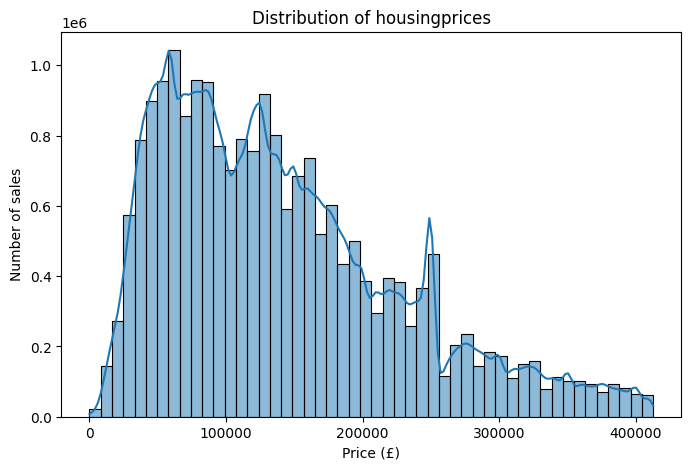

In [ ]:

plt.figure(figsize=(8, 5))
sns.histplot(df["price"], bins=50, kde=True)
plt.title("Distribution of housingprices")
plt.xlabel("Price (£)")
plt.ylabel("Number of sales")
plt.show()

## 3.2 Boxplot by property_type
-Create a boxplot to compare price distributions across different property types.

-Display each category on the x-axis with corresponding price ranges on the y-axis.


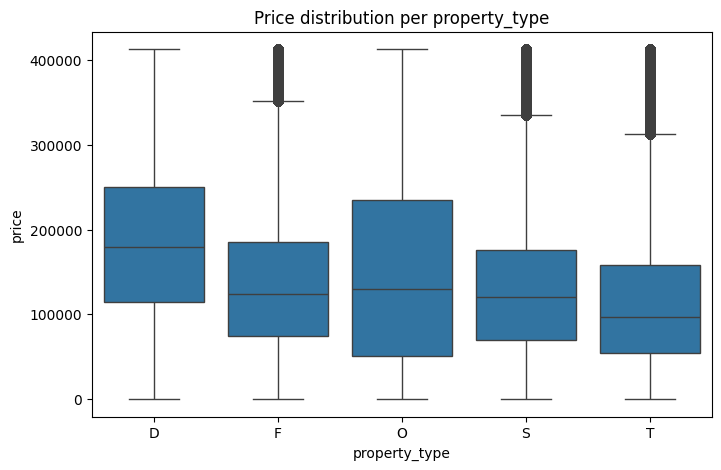

In [ ]:

if "property_type" in df.columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x="property_type", y="price")
    plt.title("Price distribution per property_type")
    plt.show()

## 3.3 Avarge price by year
-Group the dataset by year and calculate the mean price for each year.

-Build a line plot to visualize how average housing prices change over time.

-Use markers to make year-to-year shifts clearer and apply labels for readability.

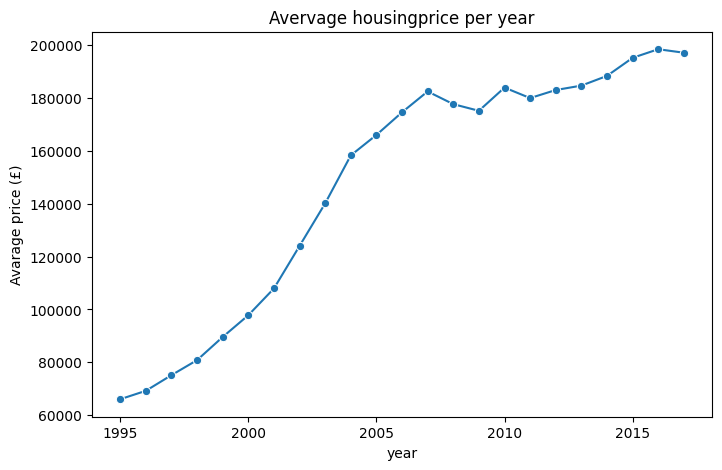

In [ ]:

if "year" in df.columns:
    price_trend = df.groupby("year", dropna=True)["price"].mean().reset_index()
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=price_trend, x="year", y="price", marker="o")
    plt.title("Avervage housingprice per year")
    plt.ylabel("Avarage price (£)")
    plt.show()

## 3.4 Feature Importance
-Check whether the feature-importance file from the external RandomForest model exists.

-Load the file and print the top 14 most important features.

-Create a barplot that visualizes the relative importance of these features.

-Apply basic formatting to keep the plot readable and well-aligned.


Top 20 most important features (RandomForest, extern model):
                              feature  importance
0                                date    0.206170
1                              county    0.187560
2                    date_of_transfer    0.171481
3                       property_type    0.120308
4       transaction_unique_identifier    0.099121
5                            district    0.079300
6                                town    0.062932
7                               month    0.039808
8                              tenure    0.012652
9                      new_build_flag    0.011736
10                               year    0.006696
11                   ppdcategory_type    0.002235
12               price_is_outlier_iqr    0.000000
13  record_status___monthly_file_only    0.000000


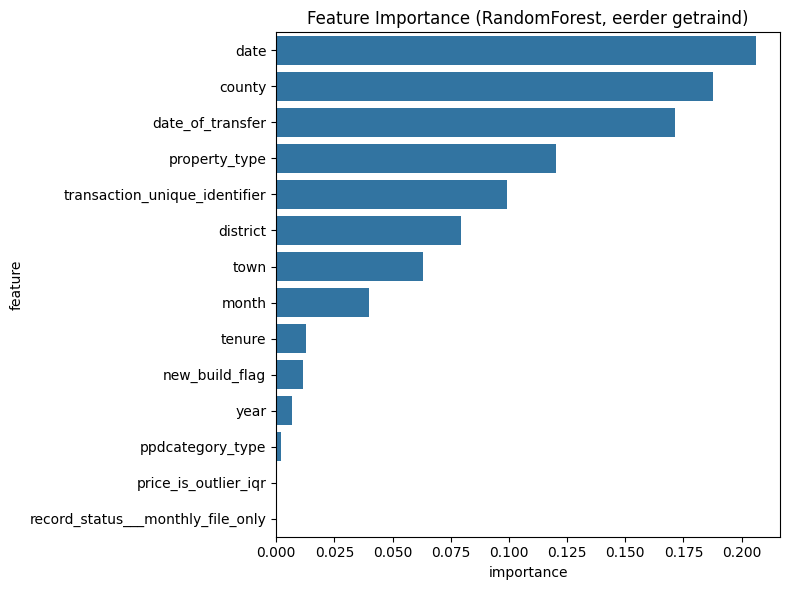

In [ ]:
fi_path = "feature_importances_rf.csv"

if os.path.exists(fi_path):
    fi_df = pd.read_csv(fi_path)

    print("\nTop 14 most important features (RandomForest, extern model):")
    print(fi_df.head(14))

    plt.figure(figsize=(8, 6))
    sns.barplot(data=fi_df.head(20), x="importance", y="feature")
    plt.title("Feature Importance (RandomForest, eerder getraind)")
    plt.tight_layout()
    plt.show()
else:
    print(f"\n No feature importance found on path: {fi_path}")


# 4 Save cleaned dataset for modeling

In [ ]:
cleaned_path = "cleaned_uk_housing2.csv"
df.to_csv(cleaned_path, index=False)
print(f"\n Cleaned dataset saved to {cleaned_path}")



✅ Cleaned dataset saved to cleaned_uk_housing2.csv
